# Redes neuronales junto con NeuralODEs

Vamos a mezclar los ejemplos vistos anteriormente, para ello vamos a crear una red neuronal la cual también pase por una NeuralODE

In [ ]:
using Flux
using DifferentialEquations
using DiffEqFlux
using Plots
using Flux: train!
using Distributions

Comenzamos como simpre generando los dastos que vamos a utilizar

In [ ]:
function Noise_Sine(x)
    return sin(2π*x) + rand(Normal(0,0.1))
end;

In [ ]:
t_train = Float32.(hcat(-1:0.01:1...))
t_train_normalized = Float32.((t_train .- mean(t_train)) ./ std(t_train))
y_train = Float32.(Noise_Sine.(t_train_normalized))
trange = t_train_normalized[1,:]
tspan = (t_train_normalized[1], t_train_normalized[end]);

In [ ]:
scatter(trange, y_train[1,:], label="training data", title="Sine function with noise")

Vamos a crear el modelo, en este caso vamos a usar la primera red que funcionó bastante bien y luego que esta pase por una NeuralODE como la de la parte 3

In [39]:
dudt = Chain(Dense(1 => 10, relu),
            Dense(10 => 25, relu),
            Dense(25 => 1, relu))

Chain(
  Dense(1 => 10, relu),                 # 20 parameters
  Dense(10 => 25, relu),                # 275 parameters
  Dense(25 => 1, relu),                 # 26 parameters
)                   # Total: 6 arrays, 321 parameters, 1.629 KiB.

A esta NN la vamos a hacer pasar por una NerualODE y extraemos los paráemtros de este modelo

In [40]:
n_ode = NeuralODE(dudt, tspan, Tsit5(), saveat = trange)
ps = Flux.params(n_ode)

Params([Float32[-0.3488699, -0.11004753, 0.24462353, 0.024742061, 0.082833774, -0.7192191, 0.10184537, 0.25695044, 0.45481572, -0.54093945  …  -0.05352537, 0.13317063, -0.20138322, -0.07774111, 0.12279995, -0.18883674, -0.31766945, 0.3222506, 0.36885217, 0.0]])

Creamos una función para crear las predicciones de la NODE empezando en el tiempo inicial t0.

In [41]:
t0 = Float32.([t_train_normalized[1]])
function predict_n_ode()
    n_ode(t0)
end

predict_n_ode (generic function with 1 method)

Creamos la función costo para esta red neruronal, igual que antes usamos mse

In [42]:
loss_node() = mean(abs2,predict_n_ode()[1,:] .- y_train[1,:]);

Veamos como se ve inicialente las predicciones de la red neuronal

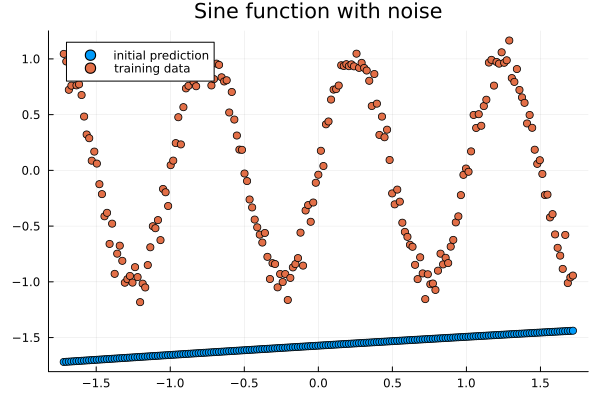

In [43]:
pred0 = predict_n_ode()
scatter(trange, pred0[1,:], label="initial prediction", title="Sine function with noise")
scatter!(trange, y_train[1,:], label = "training data")

Seteamos la cantidad de épocas a entrenar, el ratio de aprendizaje y el modelo de optimización que vamos a utilizar. Además creamos la función callback para obtener información de cada época de entrenamiento

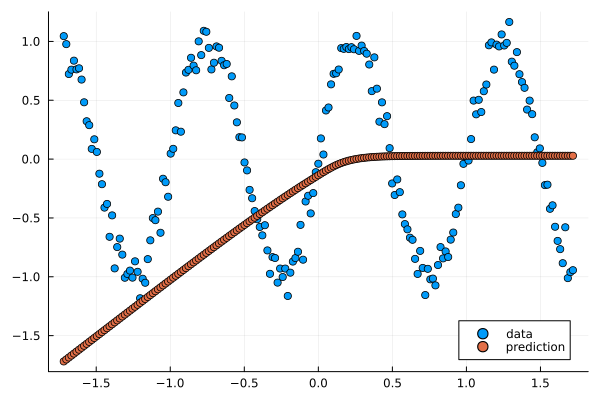

Epoch: 100 | Loss: 1.0078788

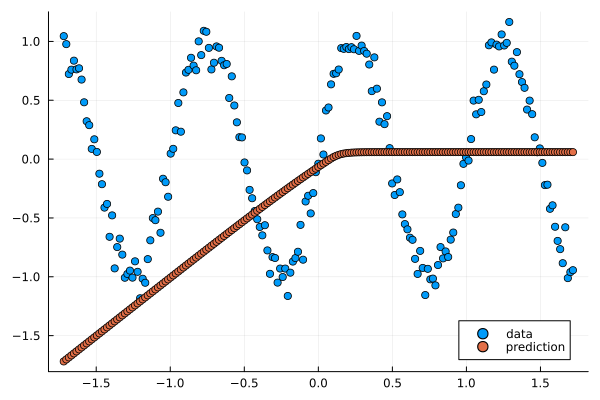


Epoch: 200 | Loss: 0.9923314

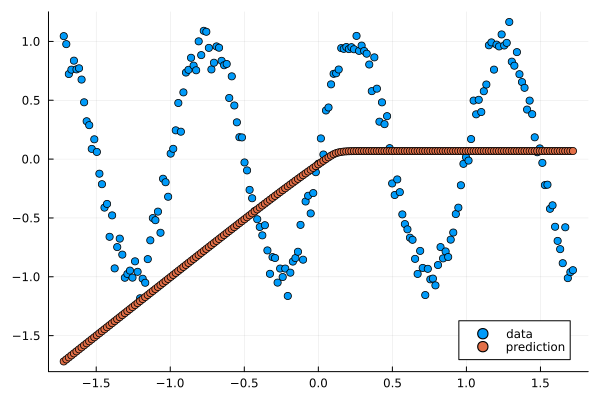


Epoch: 300 | Loss: 0.989623

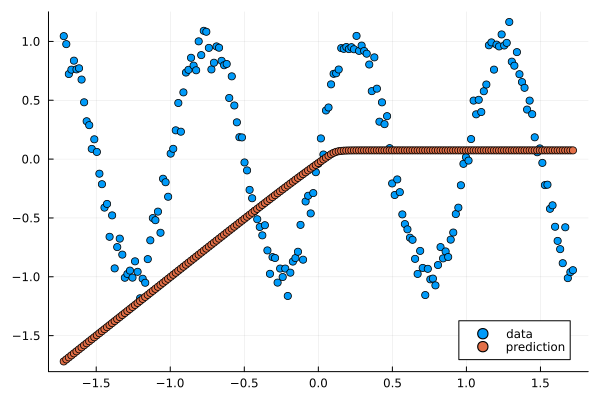


Epoch: 400 | Loss: 0.98866516


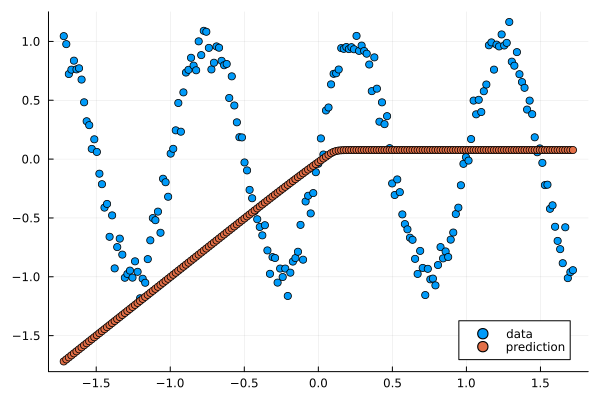

Epoch: 500 | Loss: 0.9885632

In [38]:
data = Iterators.repeated((), 500)
learning_rate = 0.005
opt = BFGS(learning_rate)
iter = 0
losses = []
cb = function () #callback function to observe training
  global iter += 1
  actual_loss = loss_node()
  if(iter%100 == 0)
    cur_pred = predict_n_ode()
    println("Epoch: $iter | Loss: $actual_loss")
    pl = scatter(trange,y_train[1,:],label="data")
    scatter!(pl,trange,cur_pred[1,:],label="prediction")
    display(plot(pl))
  end
  push!(losses, actual_loss)
end

Flux.train!(loss_node, ps, data, opt, cb = cb)
